## AutoEncoders on PointClouds - ORIONG Code

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_ae import Configuration as PN_Conf

from general_tools.in_out import create_dir
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


sys.path.insert(0, '/orions4-zfs/projects/lins2/Lin_Space/Git_Repos/tf_lab/external/Chamfer_EMD_losses/')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_path = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_manifold_meshes/1024/03001627/'
train_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/'

experiment_name = 'denoising-chairs-pnet_complex_decoder'
train_dir = osp.join(train_dir, experiment_name)

create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/denoising-chairs-pnet_complex_decoder'

In [4]:
file_names = pio.load_filenames_of_input_data(data_path)


pclouds_original, model_names_original = pio.load_crude_point_clouds(file_names=file_names, n_threads=11)


# train_data_, val_data_, test_data_ = pio.train_validate_test_split([pclouds_original, model_names_original],
#                                                                    train_perc=0.8,
#                                                                    validate_perc=0.1,
#                                                                    test_perc=0.1,
#                                                                    seed=seed)

# train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
# val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
# test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

6778 files containing  point clouds were found.


In [31]:
# def reset_graph():
#     if 'sess' in globals() and sess:
#         sess.close()
#     tf.reset_default_graph()


# conf = PN_Conf(n_input = [1024, 3],
#                training_epochs = 100,
#                batch_size = 40,
#                loss = 'l2',
#                train_dir = train_dir,
#                loss_display_step = 1,               
#                saver_step = 5,
#                learning_rate = 0.0002,
#                debug = True               
#               )

# reset_graph()

# ae = PointNetAutoEncoder(experiment_name, conf)

# if conf.debug:
#     ae.train_names = set(train_data_[1])

# ae.train(train_data, conf)

In [6]:
from general_tools.in_out.basics import files_in_subdirs
top_directory = '/orions4-zfs/projects/lins2/Lin_Space/DATA/ImcompleteScanningPointClouds/03001627/'
noisy_pcloud_files = []
search_pattern = 'compressed_scan_0_noisy00000.txt'

for file_name in files_in_subdirs(top_directory, search_pattern + '$'):
    noisy_pcloud_files.append(file_name)

noisy_pclouds, noisy_model_names = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, n_threads=11)
noisy_model_names = 'bug_here'
noisy_model_names = []
d = {name:i for i, name in enumerate(model_names_original)}
mapping = [] # The i-th noisy pcloud will correspond to the mapping[i] in the original order.


for f in noisy_pcloud_files:
    name = f.split('/')[-2]
    mapping.append(d[name])  # TODO vectorize
    noisy_model_names.append(name)  

mapping = np.array(mapping)

In [7]:
pclouds_orig_sub = pclouds_original[mapping]
noisy_pclouds_processed = noisy_pclouds.copy()
for i, pc in enumerate(noisy_pclouds):
    pc_ = Point_Cloud(points=pc)
    pc_.lex_sort()
    pc_.center_in_unit_sphere()
    noisy_pclouds_processed[i] = pc_.points

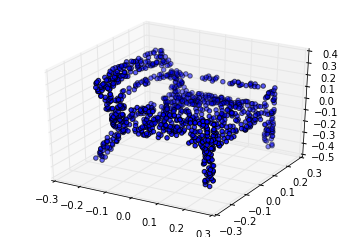

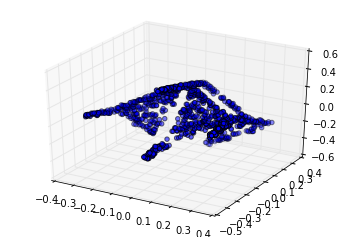

In [9]:
# TODO: Have to investigate here more.
temp = 18
Point_Cloud(points=pclouds_orig_sub[temp]).plot();
Point_Cloud(points=noisy_pclouds_processed[temp]).plot();

In [10]:
noisy_model_names = np.array(noisy_model_names, dtype=object)
train_data_, _, test_data_ = pio.train_validate_test_split([pclouds_orig_sub, 
                                                            noisy_pclouds_processed, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

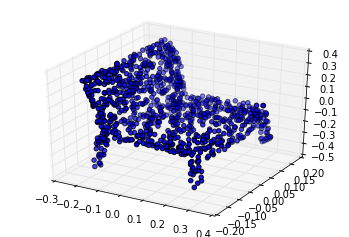

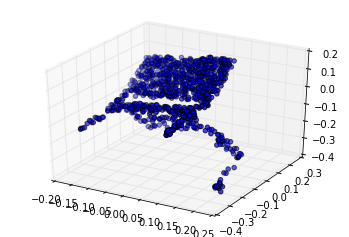

In [104]:
train_data = PointCloudDataSet(train_data_[0], noise=train_data_[1], labels=train_data_[2])
test_data = PointCloudDataSet(test_data_[0], noise=test_data_[1], labels=test_data_[2])

# TRY ME.
pp = train_data.next_batch(1)
Point_Cloud(points=pp[0].reshape(1024, 3)).plot();
Point_Cloud(points=pp[2].reshape(1024, 3)).plot();

In [21]:
import tf_lab.models.point_net_based_AE as pnAE

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf = PN_Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = train_dir,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.0002,
               debug = False,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = pnAE.decoder,
               spatial_trans = True,               
               denoising = True
              )

reset_graph()

ae = PointNetAutoEncoder(experiment_name, conf)

# if conf.debug:
#     ae.train_names = set(train_data_[1])

ae.train(train_data, conf)


('Epoch:', '0001', 'training time (minutes)=', '1.7673', 'loss=', '0.013396031')
('Epoch:', '0002', 'training time (minutes)=', '0.1342', 'loss=', '0.003718698')
('Epoch:', '0003', 'training time (minutes)=', '0.1344', 'loss=', '0.003526837')
('Epoch:', '0004', 'training time (minutes)=', '0.1355', 'loss=', '0.003487331')
('Epoch:', '0005', 'training time (minutes)=', '0.1345', 'loss=', '0.003412327')
('Epoch:', '0006', 'training time (minutes)=', '0.1399', 'loss=', '0.003375816')
('Epoch:', '0007', 'training time (minutes)=', '0.1386', 'loss=', '0.003243344')
('Epoch:', '0008', 'training time (minutes)=', '0.1373', 'loss=', '0.003096079')
('Epoch:', '0009', 'training time (minutes)=', '0.1349', 'loss=', '0.002995273')
('Epoch:', '0010', 'training time (minutes)=', '0.1351', 'loss=', '0.002971443')
('Epoch:', '0011', 'training time (minutes)=', '0.1357', 'loss=', '0.002936782')
('Epoch:', '0012', 'training time (minutes)=', '0.1366', 'loss=', '0.002912542')
('Epoch:', '0013', 'training

[(1, 0.013396031217693928, 106.0357711315155),
 (2, 0.0037186980979251011, 8.051426887512207),
 (3, 0.0035268372018998932, 8.06477403640747),
 (4, 0.0034873313492252713, 8.129625082015991),
 (5, 0.0034123265206636418, 8.067061185836792),
 (6, 0.0033758155851890998, 8.392357110977173),
 (7, 0.00324334443125519, 8.314802885055542),
 (8, 0.0030960794205644299, 8.238590002059937),
 (9, 0.0029952726465472508, 8.095373153686523),
 (10, 0.0029714432450765301, 8.10575008392334),
 (11, 0.0029367822349914128, 8.141109943389893),
 (12, 0.0029125419428705107, 8.197021961212158),
 (13, 0.002879699597889114, 8.14986801147461),
 (14, 0.0028770153848676101, 8.07892394065857),
 (15, 0.0028573937874863901, 8.232253074645996),
 (16, 0.0028380475788643317, 8.269779920578003),
 (17, 0.0028210848658567385, 8.141254186630249),
 (18, 0.0028125343655812599, 8.256824970245361),
 (19, 0.0028107863645778879, 8.467581987380981),
 (20, 0.002827287978670072, 8.290215015411377),
 (21, 0.0027871585140625634, 8.1543059

In [51]:
def eval_model(model, configuration, datasets, epochs=None):
    conf = configuration
    if type(datasets) != list:
        datasets = [datasets]

    if epochs is None:
        epochs = read_saved_epochs(conf.train_dir)

    stats = np.zeros((len(epochs), len(datasets)))
    for i, epoch in enumerate(epochs):
        model.restore_model(conf.train_dir, epoch)
        for j, d in enumerate(datasets):
            _, loss, _ = model.evaluate(d, conf)
            stats[i, j] = loss
    
    epochs = np.array(epochs).reshape((len(epochs),1))
    stats = np.hstack((epochs, stats))
    return stats



# # gen_error, best_epoch, stats = generalization_error(ae, train_data, test_data, None, conf)

# # _, loss_tes, _ = ae.evaluate(test_data, conf)
# # _, loss_val, _ = ae.evaluate(val_data, conf)

# # if loss_val < loss_tes:
# #     print 'val winner'
# # else:
# #     print 'test winner'

In [105]:
from tf_lab.autopredictors.evaluate.basics import read_saved_epochs, generalization_error
stats = eval_model(ae, conf, [train_data, test_data], range(10, 1000, 50))

Model restored in epoch 10.
Model restored in epoch 60.
Model restored in epoch 110.
Model restored in epoch 160.
Model restored in epoch 210.
Model restored in epoch 260.
Model restored in epoch 310.
Model restored in epoch 360.
Model restored in epoch 410.
Model restored in epoch 460.
Model restored in epoch 510.
Model restored in epoch 560.
Model restored in epoch 610.
Model restored in epoch 660.
Model restored in epoch 710.
Model restored in epoch 760.
Model restored in epoch 810.
Model restored in epoch 860.
Model restored in epoch 910.
Model restored in epoch 960.


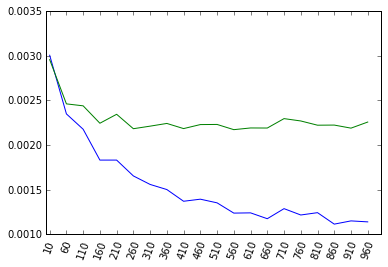

In [106]:
fig, ax = plt.subplots();
x = range(10, 1000, 50);
plt.plot(x, stats[:,1]);
plt.plot(x, stats[:,2]);
plt.xticks(rotation=70);
ax.set_xticks(x);

# np.set_printoptions(suppress=True)
# for s in stats[:,1]:
#     print '%.9f' % (s, )

In [143]:
# from tf_lab.autopredictors.plotting.basics import plot_reconstructions_at_epoch
# plot_reconstructions_at_epoch(110, ae, test_data, conf, conf.train_dir, max_plot=20)

In [142]:
def plot_original_pclouds_vs_reconstructed(original_batches, recon_batches, save_dir, max_plot=None):
    '''Example:
    ae.restore_model(conf.train_dir, epoch)
    reconstructed, loss, original = ae.evaluate(train_data, conf)
    original_pclouds_vs_reconstructed(original, reconstructed, out_dir)
    '''
    counter = 0
    plt.ioff()
    create_dir(save_dir)
    for ob, rb in zip(original_batches, recon_batches): # Itereate over batches
        for oi, ol, ri, rl in zip(ob[0], ob[1], rb[0], rb[1]): # Iterate over pclouds inside batch (pcloud-label)
            if ol != rl:
                raise ValueError()
            counter += 1
            if max_plot and counter > max_plot:
                return

            fig = Point_Cloud(points=oi).plot(show=False)
            fig.savefig(osp.join(save_dir, '%s_original.png' % (ol, )))
            plt.close()

            fig = Point_Cloud(points=ri).plot(show=False)
            fig.savefig(osp.join(save_dir, '%s_reconstructed.png' % (rl, )))
            plt.close()



In [146]:
ae.restore_model(conf.train_dir, 110)
ae.evaluate(test_data, conf)
reconstructed, _, original = ae.evaluate(test_data, conf)
plot_original_pclouds_vs_reconstructed(original, reconstructed, conf.train_dir, max_plot=20)


Model restored in epoch 110.
